# Capstone 2
## <span style="color:green">Spotify x Billboard 'Hit' Predictor</span> 

With the emergence of social media platforms in the late 1990s, the popularity of independent artists (musicians without record label contracts/representation) and single-song production has risen. As a result, revenues in the music industry have declined causing many artists to reconsider the benefits of partnership with record labels.  This sentiment has pressured executives at record label companies to consider two propositions to remain competitive with independent artists, and to remain an attractive option for current and incoming artists: assist in developing strong social media presence, or <u>develop a data-driven model capable of identifying songs worthy of Billboard status (i.e. which would consequently result in increased streams and revenue).</u>  

**Problem Statement:** How can we build a model with at least 75% accuracy to identify songs that are likely to become Billboard successes based on their Spotify APIS through a systemic analysis of song records from 1990-2019?

Success criterion for the analysis will be established by:

<li> Identification of song attributes that distinguish Billboard success ('Hit' or 'Flop') </li>
<li> Building an model that can accurately (accuracy of at least 75%) predict a ‘Hit Song’  </li>

These two outcomes will put record labels in a better position to consult artists on the viability of their success (maintaining/growing the client base) and allow the record labels to focus on releasing songs that meet the attribute thresholds of successful songs.
    
Songs were analyzed from three decades (1990s, 2000s, and 2010s) to determine which song features are correlated with hits, and which model can be constructed from these features with the best accuracy.


## Set Up
### Step 1: <span style="color:green">Import Libraries</span> 
The following libraries and packages will be used throughout the analysis 

In [1]:
## Descriptive and Inferential Stats 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

##Predictive Model
import statsmodels as sm
import sklearn 
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, precision_score, recall_score

## remove warning messages 
import warnings
warnings.filterwarnings('ignore')

### Step 2: <span style="color:green">Load Data</span> 
Retrieve the data sets for 1990s, 2000s, and 2010s 

In [2]:
nineties = pd.DataFrame(pd.read_csv('dataset-of-90s.csv'))
thousands = pd.DataFrame(pd.read_csv('dataset-of-00s.csv'))
tens = pd.DataFrame(pd.read_csv('dataset-of-10s.csv'))

### Step 3: <span style="color:green">Data Cleansing/Preparartion</span> 
Combine data frames, check for nulls, check for duplicates, etc.

In [3]:
## adding a column for decade to each dataset

nineties['decade']= 1990
thousands['decade']= 2000
tens['decade']= 2010


In [4]:
## combine data frames and save to a new csv

all_songs = [nineties, thousands, tens]
df=pd.concat(all_songs)


df.to_csv('df.csv', index = False) ## create the new csv
df.groupby('decade').head(1) ## check that the new dataframe has each decade

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Misty Roses,Astrud Gilberto,spotify:track:50RBM1j1Dw7WYmsGsWg9Tm,0.527,0.316,1,-15.769,1,0.0310,0.693,0.00699,0.1680,0.543,116.211,158840,4,53.89523,6,0,1990
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368,0.00000,0.1590,0.532,133.061,196707,4,30.88059,13,1,2000
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.020,0.00000,0.0828,0.706,108.029,188493,4,41.18681,10,1,2010


In [5]:
## check for nulls and duplicates to determine if the data needs to be cleaned
pd.isnull(df).sum()

track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
decade              0
dtype: int64

In [6]:
## Drop any duplicate rows based on track title and corresponding artist
df = df.drop_duplicates(subset=['track', 'artist'],keep='first')


No nulls, and the duplicate Song/Artist rows have been removed! 
Now let's convert duration_ms into minutes  

In [7]:
## Converting to minutes will make the scale of duration times a little easier to work with than milliseconds
df['duration_min']=round(df['duration_ms']/1000/60, 2)
df['duration_min']

0       2.65
1       6.46
2       3.95
3       6.27
4       7.18
        ... 
6393    2.51
6394    2.53
6395    3.80
6396    3.56
6397    5.69
Name: duration_min, Length: 17362, dtype: float64

Now lets generate a list of variables to be analyzed from the column names. 

In [8]:
df.columns 

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'decade', 'duration_min'],
      dtype='object')

Create a list of variables using Spotify's features (retrieved from https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) to be reused throughout the analysis.

In [9]:
spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']


## Descriptive Statistics
### Step 4: <span style="color:green">Preliminary Observations</span> 
First we'll look at the dataframe as a whole before dividing into two dataframes: Hits vs Flops (target = 1 or 0). 

In [10]:
## Preliminary descriptive statistics
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,duration_min
count,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,1.736200e+04,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000,17362.000000
mean,0.559860,0.655534,5.269036,-8.368586,0.652632,0.088807,0.240249,0.157978,0.196683,0.485989,121.053226,2.494776e+05,3.923050,40.964088,10.795473,0.502246,2000.385900,4.157976
std,0.187469,0.246079,3.563331,5.302304,0.476148,0.092832,0.307832,0.308222,0.167195,0.255124,29.909889,1.119149e+05,0.378197,19.964160,4.744401,0.500009,8.174183,1.865268
min,0.057600,0.000251,0.000000,-49.253000,0.000000,0.022000,0.000000,0.000000,0.013000,0.000000,34.535000,1.592000e+04,0.000000,0.000000,1.000000,0.000000,1990.000000,0.270000
25%,0.438000,0.505000,2.000000,-9.919000,0.000000,0.035700,0.009080,0.000000,0.093800,0.278250,97.149000,1.997632e+05,4.000000,27.902563,8.000000,0.000000,1990.000000,3.330000
50%,0.577000,0.699000,5.000000,-6.913500,1.000000,0.050400,0.082700,0.000044,0.128000,0.487000,119.876000,2.331265e+05,4.000000,36.271890,10.000000,1.000000,2000.000000,3.890000
75%,0.697000,0.856000,8.000000,-5.036000,1.000000,0.096700,0.378750,0.058800,0.257000,0.690000,140.003000,2.763132e+05,4.000000,48.324433,12.000000,1.000000,2010.000000,4.607500
max,0.986000,0.999000,11.000000,1.137000,1.000000,0.956000,0.996000,0.998000,0.992000,0.996000,217.872000,4.170227e+06,5.000000,262.615400,169.000000,1.000000,2010.000000,69.500000


Now let's compare the means for hit songs and flop songs, as well as their standard deviations, specifically using Spotify's metrics.

In [11]:
df_hits = df[spotify].loc[df['target']==1]
df_flops = df[spotify].loc[df['target']==0]

hits_mean = pd.DataFrame(df_hits.describe().loc['mean'])
flops_mean = pd.DataFrame(df_flops.describe().loc['mean'])

hits_std= pd.DataFrame(df_hits.describe().loc['std'])
flops_std = pd.DataFrame(df_flops.describe().loc['std'])


diff_per = pd.DataFrame((abs((hits_mean - flops_mean)/hits_mean)*100))
diff_per2 = pd.DataFrame((abs((hits_std - flops_std)/hits_std)*100))
joined_mean = pd.concat([hits_mean,flops_mean, hits_std, flops_std, diff_per, diff_per2], axis=1)
joined_mean.columns=['Hit Mean', 'Flop Mean', 'Hit StDev', 'Flop StDev', 'Percent Difference Mean', 'Percent Difference Stdev']

joined_mean.sort_values(by='Percent Difference Mean', ascending=False)


,Hit Mean,Flop Mean,Hit StDev,Flop StDev,Percent Difference Mean,Percent Difference Stdev
instrumentalness,0.014529,0.302723,0.084454,0.376768,1983.614351,346.121682
acousticness,0.160380,0.320838,0.198031,0.371327,100.049299,87.509247
loudness,-6.650014,-10.102669,2.708912,6.564568,51.919532,142.332319
danceability,0.640398,0.478594,0.144494,0.190770,25.266150,32.026475
valence,0.540387,0.431101,0.226222,0.270433,20.223705,19.543246
liveness,0.183044,0.210444,0.147126,0.184243,14.969405,25.228099
speechiness,0.095366,0.082189,0.099744,0.084786,13.817141,14.996699
energy,0.684383,0.626425,0.172946,0.299660,8.468638,73.267250
duration_min,3.997930,4.319467,0.822691,2.501079,8.042575,204.012022
mode,0.670298,0.634807,0.470132,0.481512,5.294869,2.420682


Here we can see a difference between the means of features of Hit songs vs Flop songs, especially in terms of Instrumentalness, Acousticness, Loudness, Danceability, and Valence (in descending order of percent difference). 

### Step 5: <span style="color:green">Visualization</span> 
We've started uncovering differences between the Hit and Flop data sets - let's investigate further making use of some visualization techniques:

#### Box Plots
Using box plots, we'll observe the variation in the distribution of data and see if there are any notable trends distinguishing Hits from Flops.

First we have all feaures that have values ranging from 0 to 1.

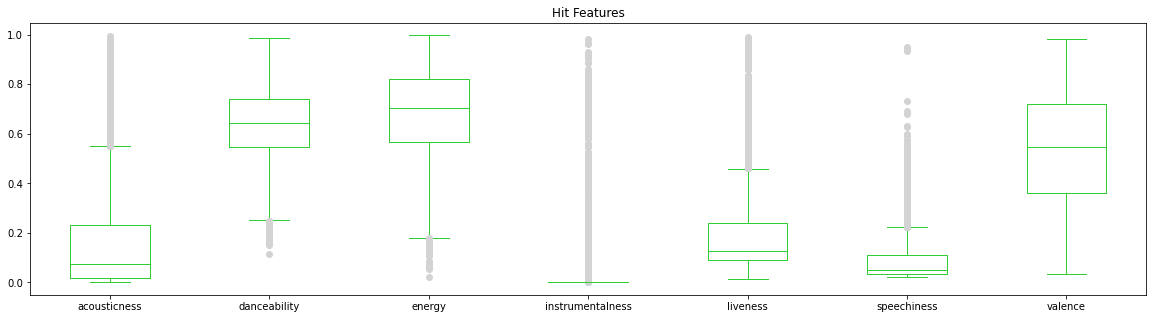

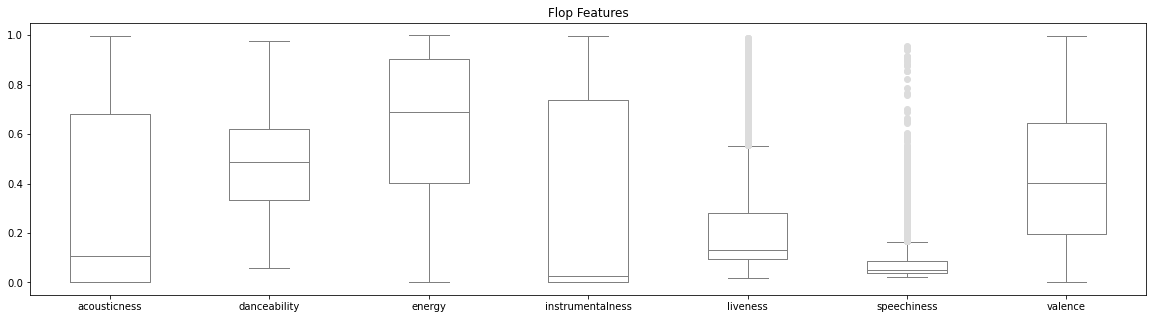

In [12]:
##To make the box plots more readable, I will break up the features based on their range of values and plot them accordingly

## The first box plots will be grouped by Hit vs Flop and display all features which have values in the range from 0 to 1

range_var= ['acousticness', 'danceability', 'energy', 'instrumentalness',
           'liveness', 'speechiness', 'valence']


mpl.rcParams['figure.figsize']=(20,5)

def box_plot(variable):
    df_hits[variable].plot(kind='box',color='limegreen', sym='lightgrey')
    plt.title('Hit Features')
    df_flops[variable].plot(kind='box', color='grey', sym = 'gainsboro')
    plt.title('Flop Features')

box_plot(range_var)








The following features are plotted on separate figures as their scale differs vastly from others. 

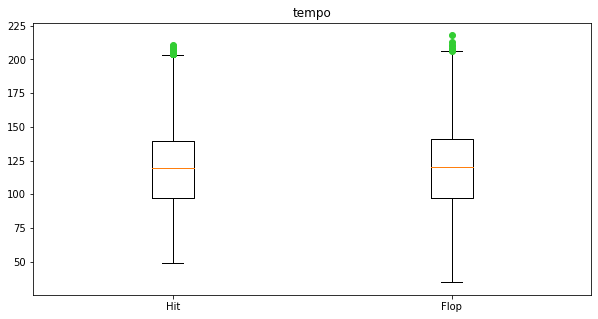

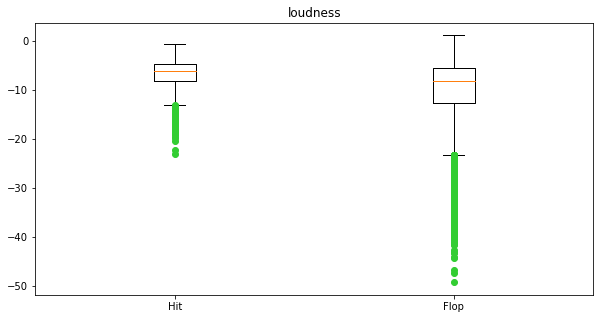

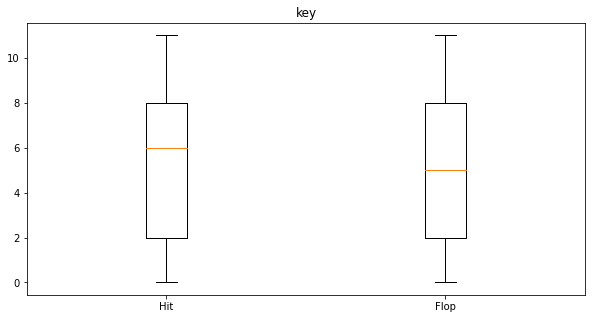

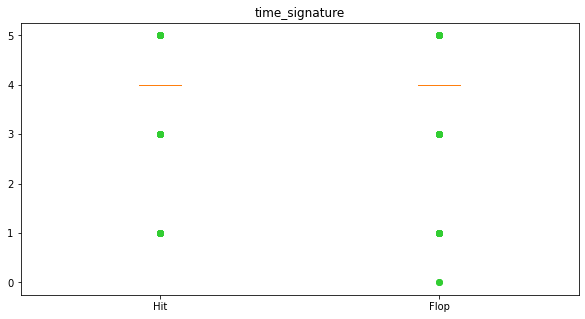

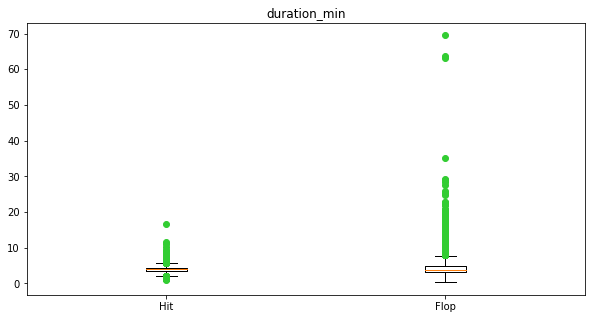

In [13]:
## Since these featuers have such different scales, I will create a function to compare the box plots of
## Hit vs Flop for each feature instead of plotting all features at once and separating by Hit vs Flop

other = ['tempo', 'loudness', 'key', 'time_signature', 'duration_min']

def box_plot(variable):
    label=[variable]
    fig, ax= plt.subplots(figsize=(10,5))
    ax.boxplot([df_hits[variable], df_flops[variable]], sym='limegreen')
    ax.set_xticklabels(['Hit', 'Flop'])
    ax.set_title(variable)
    
for variable in other:
    box_plot(variable)

Let's look at a more direct reading  of the medians:

In [14]:
hit_med= pd.DataFrame(df_hits.median())
flop_med= pd.DataFrame(df_flops.median())
medians = pd.concat([hit_med, flop_med], axis = 1)
medians.columns=['Hit Median', 'Flop Median']
medians.sort_index(ascending=True)


,Hit Median,Flop Median
acousticness,0.0762,0.1070
danceability,0.6450,0.4850
duration_min,3.9000,3.8700
energy,0.7040,0.6910
instrumentalness,0.0000,0.0274
key,6.0000,5.0000
liveness,0.1260,0.1300
loudness,-6.1420,-8.1315
mode,1.0000,1.0000
speechiness,0.0491,0.0513


We can see some (marginal) differences between the hits and flops. Namely Hits have higher median danceability, duration, energy, key, loudness, and valence. By contrast, medians for acousticness, tempo, liveness, and speechiness are lower. A more in depth look at instrumentalness may be required. 

#### Histograms 

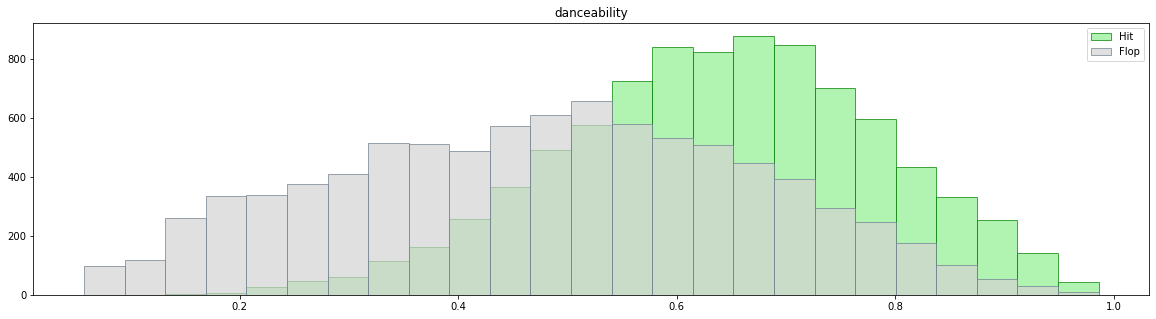

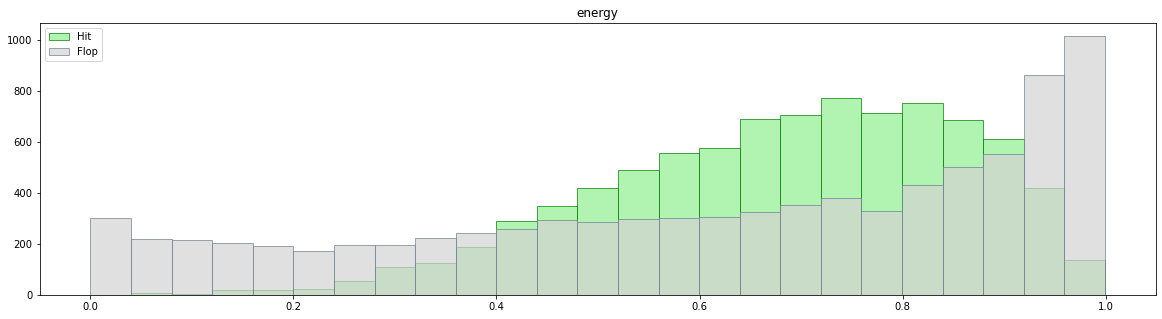

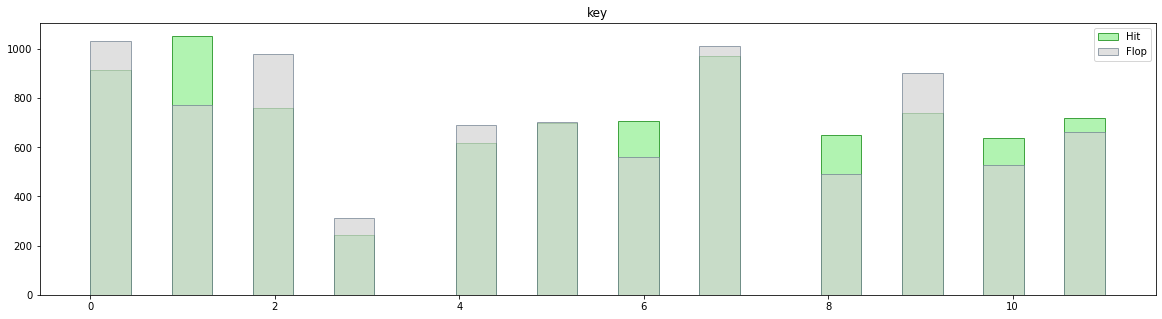

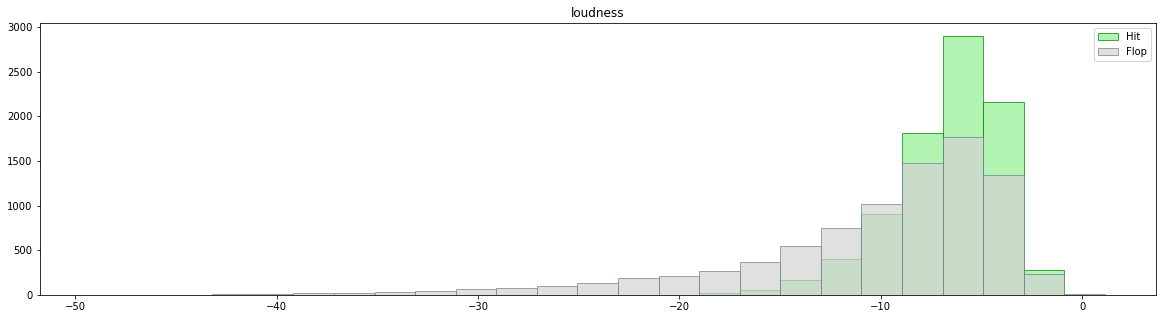

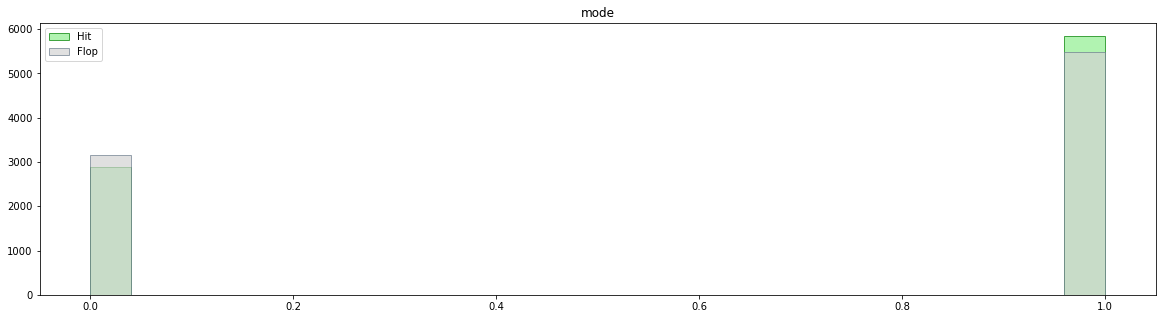

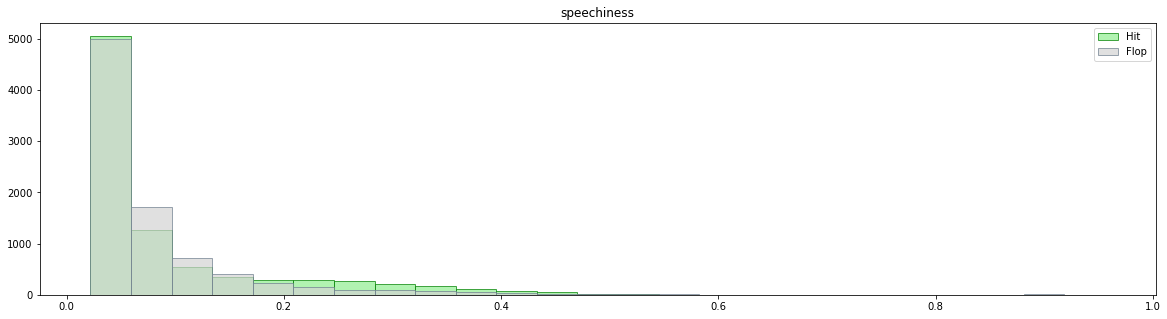

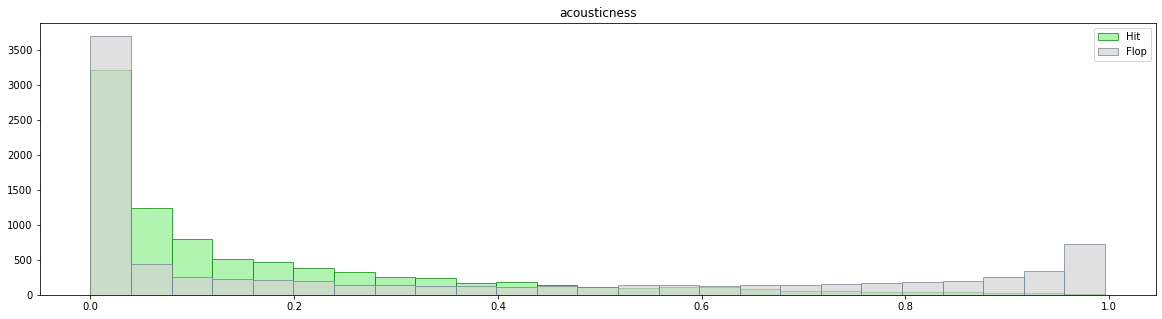

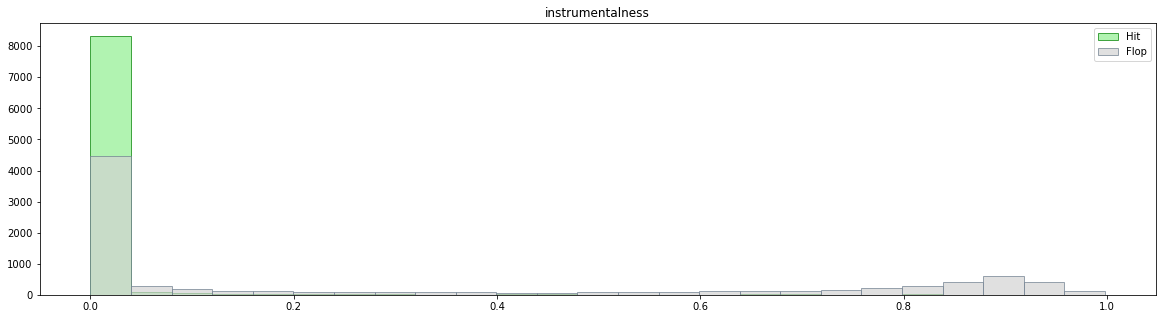

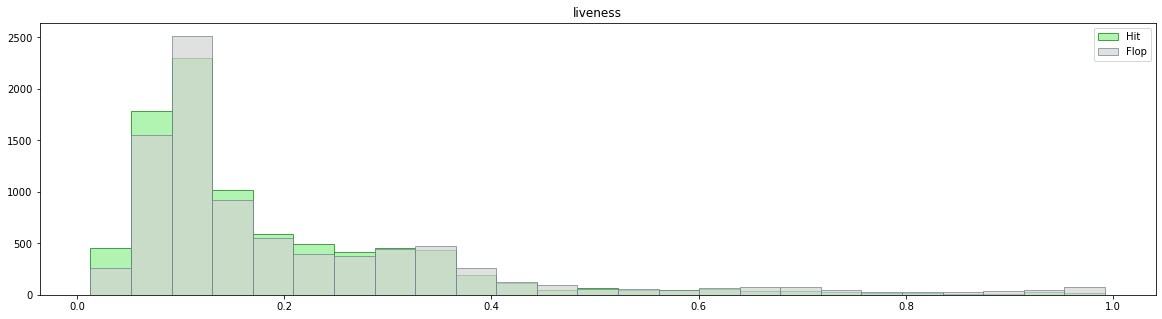

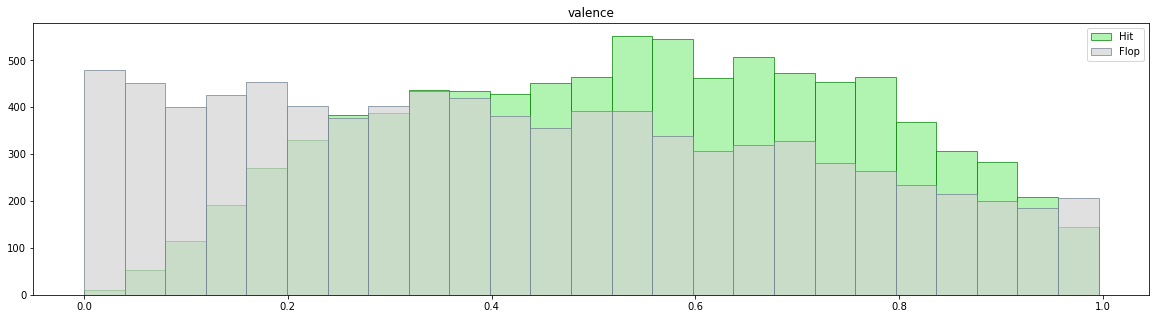

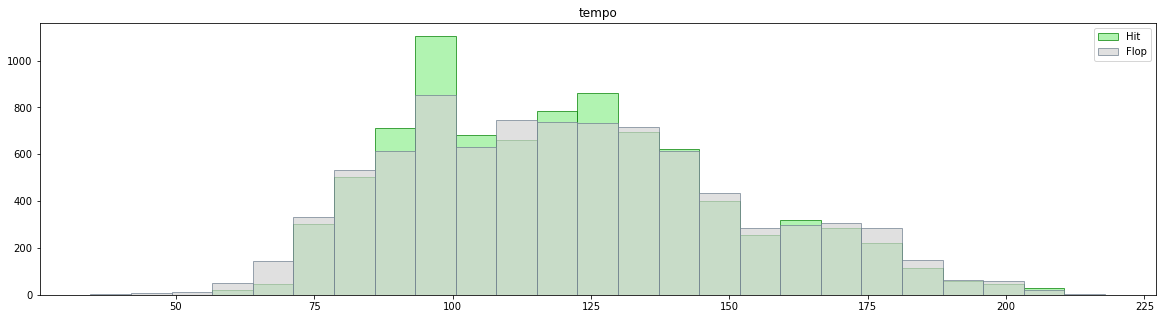

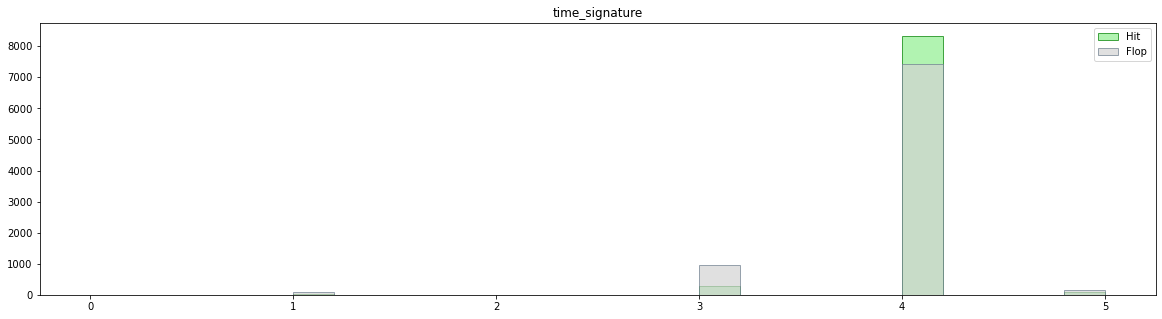

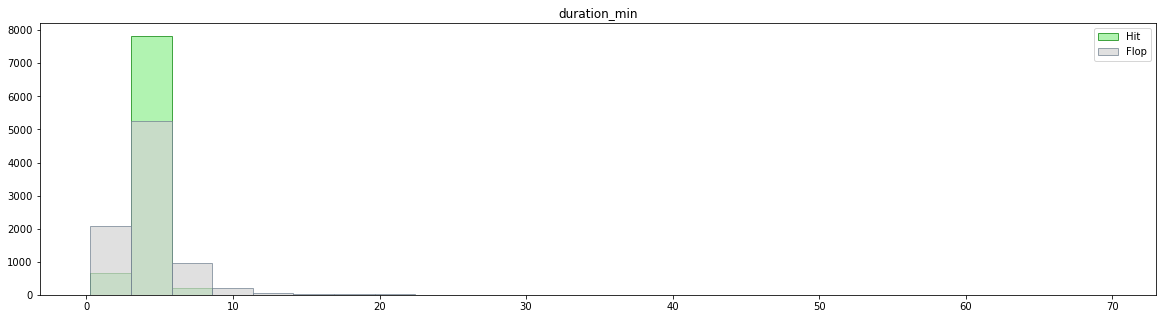

In [15]:
spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']



def hist_plot(variable):
        bins = 25
        bins = np.histogram(np.hstack((df_hits[variable], df_flops[variable])), bins=bins)[1]
        plt.hist(df_hits[variable], label='Hit', bins = bins, alpha=0.7, color='lightgreen', edgecolor='green')
        plt.hist(df_flops[variable], label='Flop', alpha=0.7, bins = bins, color='lightgrey', edgecolor='slategrey')
        plt.title(variable)
        plt.legend()
        plt.show()

for variable in spotify:
    hist_plot(variable)
    

The most insightful histograms would be danceability, loudness, valence, energy, acousticness, and instrumentalness. Danceability and Loudness both demonstrate a (mostly) central tendency for Hits whereas Flops are more widespread. Instrumentalness is at the lower end for both Flops and Hits, but Flops does indicate *some* frequency at the higher end. Valence shows a rough mirror-image for Hits vs Flops - it *may* be an important variable to consider in the analysis. 

Based on the findings so far, I believe there is enough difference between Hit and Flop songs that we can build a model to predict if a hit song can be determined from our dataset.

## Inferential Statistics
### Step 6: <span style="color:green">Preliminary Correlations: Heatmap</span> 
We will be building models based on the Spotify APIs. Therfore, let's consider the dataframe of Spotify APIs and the target column to observe the correlations between variables.

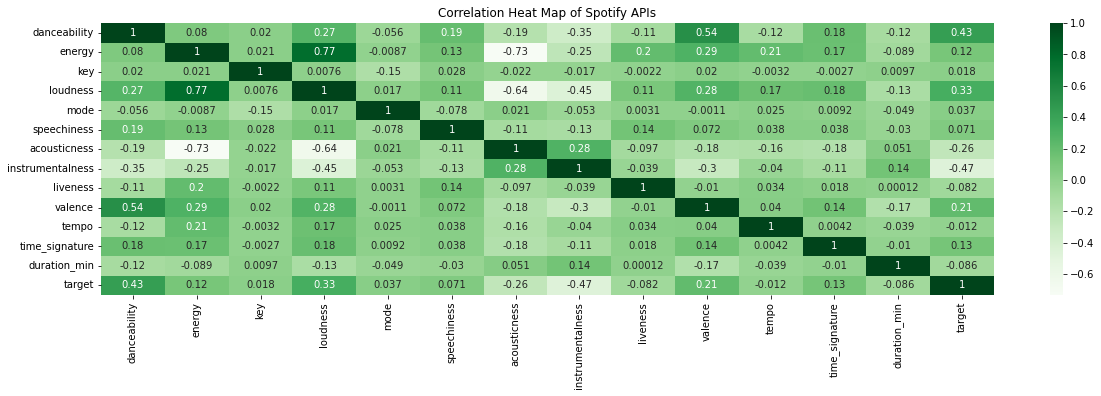

In [16]:
## create a list of spotify variables and the target variable to subset the data frame 

corr_var = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min', 'target']
correlated= df[corr_var].corr()
sns.heatmap(correlated, annot=True, cmap='Greens')
plt.title('Correlation Heat Map of Spotify APIs')
plt.show()

Now let's specifically focuse on the correlation-to-target:

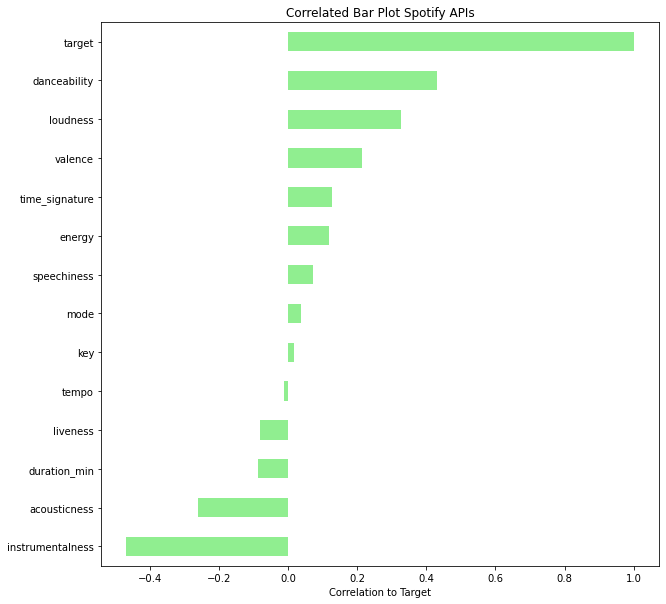

In [17]:
corr_plot = correlated['target'].sort_values(ascending=True)
corr_plot.plot(kind='barh', color='lightgreen', figsize=(10,10))
plt.title('Correlated Bar Plot Spotify APIs')
plt.xlabel('Correlation to Target')
plt.show()

The features with the highest positive correlations to hit/flop (target = 1 or 0) are danceability (0.43), loudness (0.33), and valence (0.21). The features with the highest negative correlations to hit/flop are instrumentalness (-0.47) and acousticness (-0.26). While these are considered the 'highly' correlated variables for this data, these values are still relatively low. 

## Model Training

We'll consider 3 types of supervised machine learning models: Logistic Regression, Decision Tree Classifier, and Random Forest Classifier. The independent variables we'll be using as explanatory features are the Spotify APIs, while the dependent variable will be Target (1 or 0 for Hit or Flop). For each model, the data will be split as 70% train, 30% test. 

In [18]:
## we'll be making use of the packages and libraries imported in Step 1 under Predictive Model
## we'll also be using the variables in the list Spotify as the explanatory variables

spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']

## Assign variables x and y as explanatory and dependent variables 

x = df[spotify]
y = df['target']

## split dataset into 70% train, 30% test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

### Step 7: <span style="color:green">Logistic Regression </span> 
First, we'll set up and train model:


In [19]:
## build then fit the training data to the Logistic Regression model

log = LogisticRegression()
log.fit(x_train, y_train)

print('Logistic Regression model is trained')

Logistic Regression model is trained


In [20]:
## used fitted model to create a prediction variable

y_pred = log.predict(x_test)

print('Predictive model is ready.')

Predictive model is ready.


### Step 8: <span style="color:green">Evaluating Efficacy of the Logistic Regression Model </span> 


#### Metrics and Classification Report
Accuracy gives the ratio of true positive and true negative outcomes to all observations. Precision tells us what proportion of positive outcomes are correct. Recall tells us the ability to correctly predict positives from all actual positives.  

In [21]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Logistic Regression Metrics Report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)


Logistic Regression Metrics Report:
Accuracy:  79.25 %
Precision:  76.61 %
Recall:  86.05 %
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      2521
           1       0.77      0.86      0.81      2688

    accuracy                           0.79      5209
   macro avg       0.80      0.79      0.79      5209
weighted avg       0.80      0.79      0.79      5209



#### Insights on Logistic Model:
The Logistic Regression model reflects an accuracy of 79% which meets the success criteria outlined by the problem, however for better judgement we will look at two other models and compare them before coming to a conclusion. 

### Step 9: <span style="color:green">Decision Tree Classifier </span> 

In [22]:
dtree = DecisionTreeClassifier()

dtree.fit(x_train, y_train)


print('Decision Tree model is trained')

Decision Tree model is trained


In [23]:
y_pred = dtree.predict(x_test)

print('Predictive model is ready.')

Predictive model is ready.


### Step 10: <span style="color:green">Evaluating Efficacy of the Decision Tree Model </span> 

#### Metrics and Classification Report

In [24]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Decision Tree Metrics Report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)


Decision Tree Metrics Report:
Accuracy:  75.58 %
Precision:  76.56 %
Recall:  75.93 %
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2521
           1       0.77      0.76      0.76      2688

    accuracy                           0.76      5209
   macro avg       0.76      0.76      0.76      5209
weighted avg       0.76      0.76      0.76      5209



#### Insights on Decision Tree Classifier

The Decision Tree model reflected overall lower accuracy, precision, and recall compared to the Logistic Regression model. Though it still meets the criteria of 75% accuracy, at this point the Logistic Regression may be a better choice for consideration.  

### Step 11: <span style="color:green">Random Forest Classifier </span> 
First, we'll set up and train the model:

In [25]:
## set Random Forest Classifier parameters, then fit it to the train data

rf = RandomForestClassifier(n_estimators = 400, random_state=0)
rf.fit(x_train, y_train)

print('Random Forest model is trained.') ## depending on the number of estimators it may take while, 
                                   ## so adding a print statement allows me to know when it is ready


Random Forest model is trained.


In [26]:
## use the fitted model create a prediction variable

y_pred = rf.predict(x_test)

print('Predictive model is ready.')

Predictive model is ready.


### Step 12: <span style="color:green">Evaluating Efficacy of the RF Model </span> 


#### Metrics and Classification Report

In [27]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest Metrics Report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)

Random Forest Metrics Report:
Accuracy:  83.85 %
Precision:  82.12 %
Recall:  87.83 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2521
           1       0.82      0.88      0.85      2688

    accuracy                           0.84      5209
   macro avg       0.84      0.84      0.84      5209
weighted avg       0.84      0.84      0.84      5209



#### Insights on Random Forest Classifier
We have an overall accuracy of 83.85% as well as an f1-score of 0.85 - indicating based on the dataset from 1990s-present we can predict whether a song is a Hit or Flop with 84% accuracy. It also scored high in precision and recall. 

Based on the accuracy, precision, and recall scores of the Random Forest Classifier I'd recommend moving forward with evaluating aspects of the random forest classifier model further.

#### Confusion Matrix
To see a visual representation of true positives, true negatives, false positives and false negatives (as they were used in our reporting above) we can create a confusion matrix based on the model:

In [28]:
## create the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix generated.')

Confusion matrix generated.


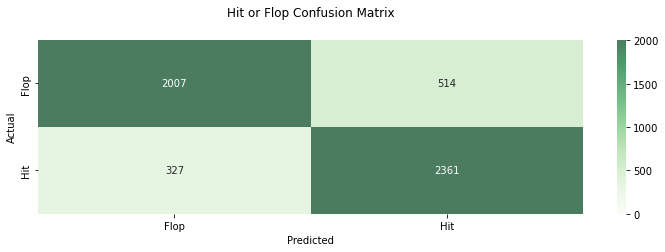

In [29]:
#create a figure/heatmap of the confusion matrix for a better visual

mpl.rcParams['figure.figsize']=(10,3)
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="Greens" ,fmt='g', vmax=2007, vmin=0, alpha = 0.7)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Hit or Flop Confusion Matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.xaxis.set_ticklabels(['Flop', 'Hit'])
ax.yaxis.set_ticklabels(['Flop', 'Hit'])
plt.show()

The confusion matrix also let's us see the ratio of True to False predictions:

(2007 +2361) / (327 + 514)  = ~ 5

Meaning that for every 5 true predictions, there was 1 false prediction.  

#### Feature Importance
The preliminary theory was that of the features in the dataframe, based on the descriptive statistics, Danceability, Loudness, and Valence would have more importance given their comparatively greater positive correlation as well as  Acousticness and Instrumentalness given their comparatively greater negative correlation. 

We will use the feature importance metric to show which features are *most* predictive in the RFC model. 

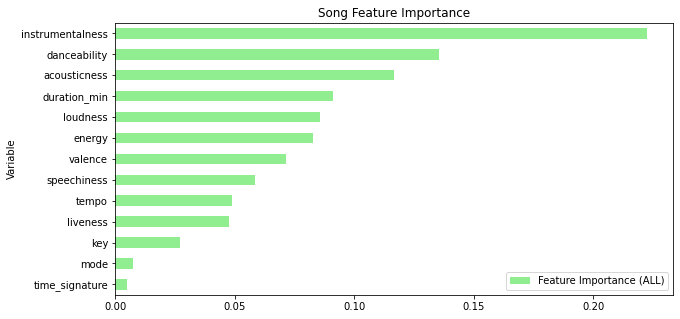

In [30]:
importance = pd.DataFrame(rf.feature_importances_)
features = pd.DataFrame(spotify)
imp_rf = pd.concat([features, importance], axis=1)
imp_rf.columns=['Variable', 'Feature Importance (ALL)']
imp_rf = imp_rf.set_index('Variable')
imp_rf = imp_rf.sort_values(by='Feature Importance (ALL)', ascending = True)


imp_rf.plot(kind='barh', color='lightgreen', figsize=(10,5))
plt.title('Song Feature Importance')
plt.show()

In [31]:
print(imp_rf.sort_values('Feature Importance (ALL)', ascending=False))

                  Feature Importance (ALL)
Variable                                  
instrumentalness                  0.222312
danceability                      0.135411
acousticness                      0.116611
duration_min                      0.091024
loudness                          0.085875
energy                            0.082927
valence                           0.071335
speechiness                       0.058428
tempo                             0.048820
liveness                          0.047522
key                               0.027034
mode                              0.007611
time_signature                    0.005089


For all decades, Instrumentalness, Danceability, Acousticness, Energy, and Duration were the greatest predictors of whether a song was a hit. As expected, Instrumentalness and Danceability appeared as top features (recall they were the highest negative and positive correlated variables). What was surprising was the importance of Duration 

In [32]:
## for later use, save the importance feature data to a new csv

All_Time = imp_rf
All_Time.to_csv('all_time.csv', index=True)

## <span style="color:green">Further Exploration: </span> 
### Can the model's efficacy be increased?

#### Case 1: Excluding Least Important Features
What about if we were to drop mode and time_signature from our independent variables? These two features have the lowest importance (below 0.01). How would this change our model?

In [33]:
x=df[spotify].drop(['mode','time_signature'], axis=1)
y=df['target']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)
rf = RandomForestClassifier(n_estimators=400, random_state=0)
rf.fit(x_train, y_train)

y_pred=rf.predict(x_test)

print('Model is ready')

Model is ready


In [34]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Metrics report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)

Metrics report:
Accuracy:  83.68 %
Precision:  81.89 %
Recall:  87.8 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      2521
           1       0.82      0.88      0.85      2688

    accuracy                           0.84      5209
   macro avg       0.84      0.84      0.84      5209
weighted avg       0.84      0.84      0.84      5209



Dropping the two least important features actually *negatively* affected to model. While it is <u>extremely minimal</u>, the accuracy, precision, and recall decreased when Mode and Time Signature are removed from the explanatory variables. To have the best performing model, then, these features will need to remain in the list of independent variables. 

#### Case 2: Limiting Scope of the Time Frame
What if we were to limit the time frame to the last 20 years (2000s-present) instead of the last three decades? How would this change the accuracy? 

In [35]:
df_2 = df[df['decade']!=1990]
x = df_2[spotify]
y = df_2['target']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state = 0)

rf=RandomForestClassifier(n_estimators=400, random_state=0)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

print('Model is ready.')

Model is ready.


In [36]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Metrics report:")
print("Accuracy: ",np.round(accuracy*100,2), '%')
print('Precision: ', np.round(precision*100, 2), '%')
print('Recall: ', np.round(recall*100, 2), '%')
print('Classification Report:')
print(report)


Metrics report:
Accuracy:  84.07 %
Precision:  80.87 %
Recall:  89.07 %
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1791
           1       0.81      0.89      0.85      1775

    accuracy                           0.84      3566
   macro avg       0.84      0.84      0.84      3566
weighted avg       0.84      0.84      0.84      3566



Specifically focusing the time frame to the last 20 years marginally improved the accuracy, and recall of the model, though it decreased in precision. However, the f1-score remained the same. 

The two proposed modifications had very little impact on the overall accuracy and f1-score of the Random Forest Classifier, therefore the original model (with all variables and decades) is recommended for further use. 

### Are there notable differences across each decade?

What if we were to subset our data back into the three decades and build a model around each of these timeframes - what differences in efficacy could we observe? Are there trends in feature importance?

In [37]:
## recall the spotify list of variables

spotify = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature','duration_min']

1990  Metrics report:
Accuracy:  85.58 %
Precision:  84.99 %
Recall:  87.5 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       796
           1       0.85      0.88      0.86       848

    accuracy                           0.86      1644
   macro avg       0.86      0.86      0.86      1644
weighted avg       0.86      0.86      0.86      1644

Song Feature Importance  1990
            Variable  Feature Importance 1990
0       danceability                 0.164550
12      duration_min                 0.156567
7   instrumentalness                 0.143847
6       acousticness                 0.129596
3           loudness                 0.076577
1             energy                 0.068840
5        speechiness                 0.067367
9            valence                 0.059797
8           liveness                 0.047839
10             tempo                 0.047378
2                key                 

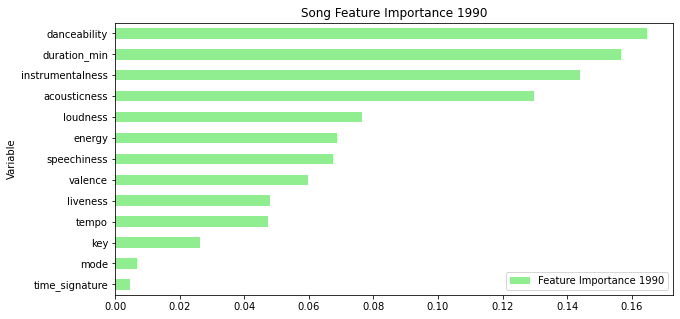

2000  Metrics report:
Accuracy:  84.14 %
Precision:  82.9 %
Recall:  86.95 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       840
           1       0.83      0.87      0.85       881

    accuracy                           0.84      1721
   macro avg       0.84      0.84      0.84      1721
weighted avg       0.84      0.84      0.84      1721

Song Feature Importance  2000
            Variable  Feature Importance 2000
7   instrumentalness                 0.232099
0       danceability                 0.135542
12      duration_min                 0.109381
3           loudness                 0.108008
6       acousticness                 0.093814
1             energy                 0.076992
9            valence                 0.065213
5        speechiness                 0.055319
10             tempo                 0.043874
8           liveness                 0.042660
2                key                 

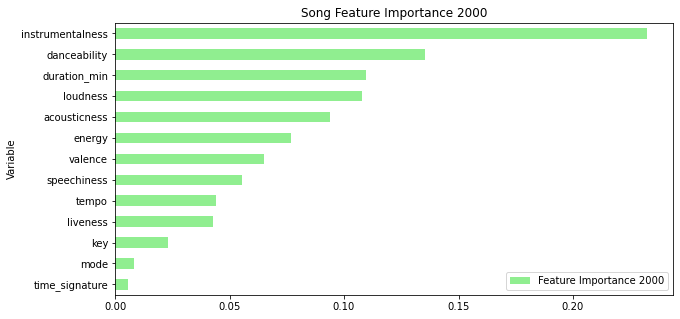

2010  Metrics report:
Accuracy:  82.66 %
Precision:  80.44 %
Recall:  88.0 %
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       887
           1       0.80      0.88      0.84       958

    accuracy                           0.83      1845
   macro avg       0.83      0.82      0.83      1845
weighted avg       0.83      0.83      0.83      1845

Song Feature Importance  2010
            Variable  Feature Importance 2010
7   instrumentalness                 0.260005
0       danceability                 0.108563
3           loudness                 0.104776
6       acousticness                 0.102196
1             energy                 0.095184
9            valence                 0.072184
12      duration_min                 0.072118
5        speechiness                 0.054811
10             tempo                 0.046249
8           liveness                 0.043765
2                key                 

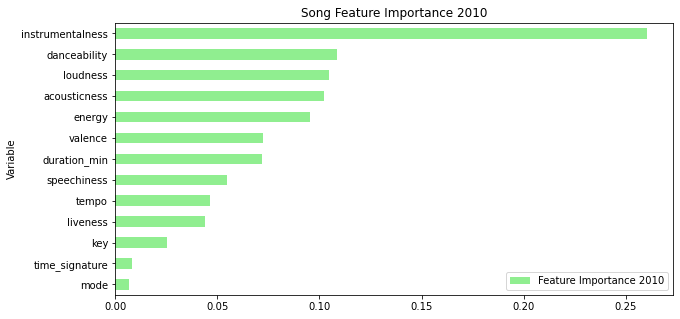

In [38]:
## build a definiton and for loop to iterate the model and metrics across each decade

Decades = [1990, 2000, 2010]
def model(year):
    data = df[df['decade']==year]  ## subset by decade
    
    ## set up the RFC
    x = data[spotify]
    y = data['target']
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state = 0)

    rf = RandomForestClassifier(n_estimators=400,random_state=0)
    rf.fit(x_train, y_train)

    y_pred=rf.predict(x_test)
    
    ## Create Metrics Report
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(year, " Metrics report:")
    print("Accuracy: ",np.round(accuracy*100,2), '%')
    print('Precision: ', np.round(precision*100, 2), '%')
    print('Recall: ', np.round(recall*100, 2), '%')
    print('Classification Report:')
    print(report)
    
    ## calculate and display feature importance
    
    importance = pd.DataFrame(rf.feature_importances_)
    features = pd.DataFrame(spotify)
    imp_rf = pd.concat([features, importance], axis=1)
    imp_rf.columns=['Variable', 'Feature Importance '+str(year)]

    print('Song Feature Importance ', year )
    print(imp_rf.sort_values('Feature Importance '+str(year), ascending=False))
    imp_rf = imp_rf.sort_values(by='Feature Importance '+str(year), ascending = True)


    imp_rf.plot(x='Variable', kind='barh', color= 'lightgreen', figsize=(10,5))
    plt.title("Song Feature Importance "+ str(year))
    plt.show()
    
    ## save each iterated decade to a new csv to call later for comparison
    decade = imp_rf
    decade.to_csv(str(year)+'_imp.csv', index=False )
    
for year in Decades:
	model(year)    

#### Now let's look at how feature importance has changed across the decades vs our all time model:

In [39]:
## using the csvs that were just created, create dataframes for each decade vs all time
the_90s = pd.DataFrame(pd.read_csv('1990_imp.csv'))
the_00s = pd.DataFrame(pd.read_csv('2000_imp.csv'))
the_10s = pd.DataFrame(pd.read_csv('2010_imp.csv'))
All_Time = pd.DataFrame(pd.read_csv('all_time.csv'))

## set the index to the variable names rather
the_90s = the_90s.set_index('Variable')
the_00s = the_00s.set_index('Variable')
the_10s = the_10s.set_index('Variable')
All_Time = All_Time.set_index('Variable')

## create a dataframe of all feature importances
compare = pd.concat([All_Time, the_90s, the_00s, the_10s], axis=1)
compare.sort_values('Feature Importance (ALL)', ascending = False)

,Feature Importance (ALL),Feature Importance 1990,Feature Importance 2000,Feature Importance 2010
Variable,,,,
instrumentalness,0.222312,0.143847,0.232099,0.260005
danceability,0.135411,0.164550,0.135542,0.108563
acousticness,0.116611,0.129596,0.093814,0.102196
duration_min,0.091024,0.156567,0.109381,0.072118
loudness,0.085875,0.076577,0.108008,0.104776
energy,0.082927,0.068840,0.076992,0.095184
valence,0.071335,0.059797,0.065213,0.072184
speechiness,0.058428,0.067367,0.055319,0.054811
tempo,0.048820,0.047378,0.043874,0.046249


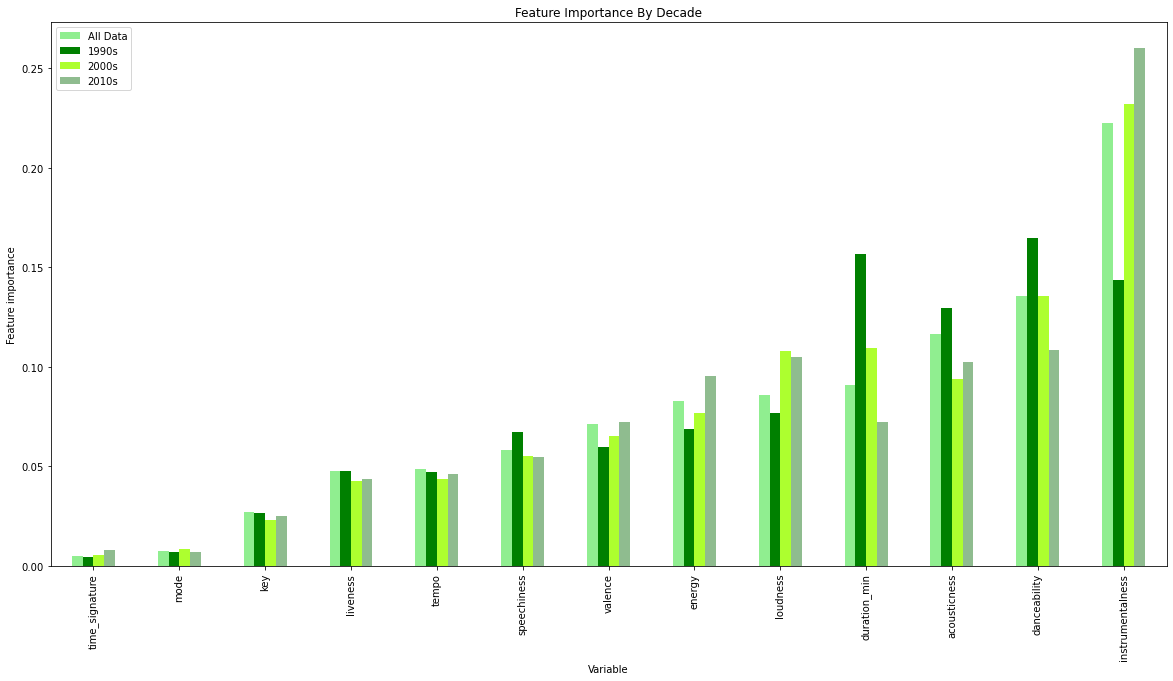

In [40]:
## plot the feature importance for each decade vs all time

compare.plot(kind='bar', color = ('lightgreen','green','greenyellow','darkseagreen' ), figsize = (20,10))
plt.ylabel("Feature importance")
plt.legend(labels=['All Data', '1990s', '2000s', '2010s'])
plt.title('Feature Importance By Decade')
plt.show()

Based on the comparison dataframe, we see that overall Instrumentalness, Danceability, Acousticness, Duration, and Loudness have the greatest overall feature importance (with the exception of the 2010s where Energy has greater importance than Duration), however the degree of importance for these attributes varies across the decades.

For example: Instrumentalness, Loudness, Energy and Valence each increased from 1990s-2010s whereas Danceability, Acousticness, and Duration all decreased. The remaining variables remained fairly consistent across the decades. 

## Insights

#### Descriptive Stats:

Based on comparing means, medians, and distributions of the Hit Songs vs Flop Songs we can observe:

All songs tended to be more Danceable with higher Energy while having less Speechincess, Instrumentalness, and Liveness (based on means across entire dataset). 

In general, we can use the following features to distinguish Hits from Flops:
Hits have low Instrumentalness and Acousticness, while they have higher Danceability, Valence, and Loudness. 

The histograms showed Flops had more widespread distributions across each feature, while Hits features like Danceability and Loudness displayed more central tendencies.

Features with very little difference between Hits and Flops include: Time Signature, Tempo, and Mode. 


#### Inferential Stats:

The features with the highest positive correlations to hit/flop (target = 1 or 0) are danceability (0.43), loudness (0.33), and valence (0.21). The features with the highest negative correlations to hit/flop are instrumentalness (-0.47) and acousticness (-0.26). While these are considered the 'highly' correlated variables for this data, these values are still relatively low.


#### Model Reporting: 

Out of all three models (Logistic Regression, Decision Tree and Random Forest Classifier), the Random Forest Classifier model had higher accuracy (84%), precision (82%), recall (88%) and f1 score (0.85). The ratio of true predictions vs false predictions was 5:1 for the Random Forest model. Hence, Random Forest Classifier is the better performing model for this data set.

Despite relatively low correlation-to-target values (none higher than 0.43 or lower than -0.47), the Ranom Forest Classifier was able to establish a baseline model with an accuracy of 84%; meaning that based on the Spotify APIs, we can predict whether a song will be a Billboard success ('Hit' or 'Flop') with 84% accuracy (success criteria achieved). 

Using the feature importance metric revealed that Instrumentalness, Danceabiity, Acousticness, Duration, and Loudness had the greatest overall impact in predicting a song's success. Evaluating models specific to each decade confirmed this trend - while there were some fluctuations in the order of importance depending on the decade, overall these 5 variables had the highest importance.

Modifying the Random Forest Classifier by dropping the variables with the lowest feature importance and limiting the scope to the last two decades had very minimal effect on the accuracy of the model. <u>Therefore, as a baseline, the original Random Forest Classifier (with all variables and decades) is the proposed solution for this problem statement</u>. 
